In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import GradientBoostingClassifier


In [2]:
def number_elements(x):
    if x != '-':
        return len(x.split(' '))
    else:
        return 0

### Loading dataset

In [3]:
df = pd.read_csv('../../data/train_cleanV4.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

#Removing NaN values
df['user_mentions'] = df['user_mentions'].fillna(value='-')
df['urls'] = df['urls'].fillna(value='-')
df['hashtags'] = df['hashtags'].fillna(value='-')
df['nbr_user_mentions'] = pd.DataFrame(df['user_mentions'].apply(lambda x: number_elements(x)))
df['nbr_hashtags'] = pd.DataFrame(df['hashtags'].apply(lambda x: number_elements(x)))
df['nbr_urls'] = pd.DataFrame(df['urls'].apply(lambda x: number_elements(x)))

df.head(3)

,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,text,nbr_user_mentions,nbr_hashtags,nbr_urls,retweet_sup_20,timestamp,hour,date,text_len
0,0,0,0.009504,9.405109e-06,0.000279,-,-,-,smh give,0,0,0,1,2020-05-05 16:42:35,16,1,13
1,0,0,0.000043,4.356590e-07,0.000046,-,-,-,us human be think miss boat georg,0,0,0,1,2020-05-03 00:15:48,0,6,69
2,0,0,0.000450,1.430841e-05,0.000529,-,-,-,old dirti trick trump like know fauci would sa...,0,0,0,1,2020-05-04 23:24:33,23,0,99


### Separate dataset into 3 class for retweet numbers

We use the 80/20 rule which means that we will chose number of retweets at 80% and 96% of the sorted list of number of retweets. This gives respectively 4 and 196 for our dataset.


- 0 : [0,4] retweets
- 1 : [4,196] retweets
- 2 : [197, inf[ retweets

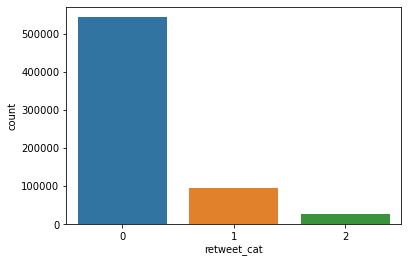

In [4]:
sup_5 = df['retweet_count'] > 5
sup_196 = df['retweet_count'] > 196 
df['retweet_cat'] = sup_5.astype(int) + sup_196.astype(int)
sns.countplot(x= 'retweet_cat', data=df)

### Let's compare 4 classification models

- RandomForest (RF)
- Logistic (LO)
- DecisionTree (DT) 
- NativeBayes (NB)

In [16]:
columns = ['user_verified', 'user_statuses_count', 'user_friends_count',
            'user_followers_count', 'nbr_user_mentions', 'nbr_hashtags', 'nbr_urls',
            'hour', 'date', 'text_len']
X = df[columns]
y = df['retweet_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [6]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

RandomForestClassifier()

In [7]:
y_pred=clf.predict(X_test)

In [8]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.92199023, 0.6004401 , 0.6331462 ]),
 array([0.9563879 , 0.55441146, 0.32657686]),
 array([0.93887411, 0.5765085 , 0.43089701]),
 array([162753,  29038,   7943], dtype=int64))

### Let's try to optimizz our random forest algorithm using the hyper parameters

In [9]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
display(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [10]:
df_sample = df.sample(10000)

X = df_sample[columns]
y = df_sample['retweet_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 150, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 13.1min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=150,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=2)

In [11]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [12]:
print('Breaking point')
assert False, "breakpoint"

Breaking point


AssertionError: breakpoint

In [17]:
X = df[columns]
y = df['retweet_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [18]:
clf_new = RandomForestClassifier(n_estimators = 2000, min_samples_split=5, min_samples_leaf=4, max_features='sqrt', max_depth = 15, bootstrap=True)
clf_new.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=2000)

In [19]:
y_pred=clf_new.predict(X_test)

In [20]:
precision_recall_fscore_support(y_test, y_pred, average='weighted')

(0.8584793692724589, 0.8689156578249071, 0.8574718988305935, None)

In [21]:
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

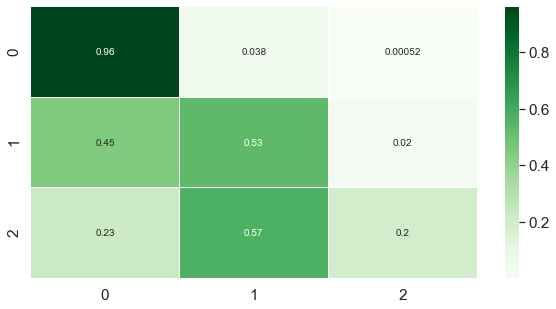

In [22]:
plt.figure(figsize=(10,5))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

### Evaluation on the eval_dataset

In [23]:
eval_data = pd.read_csv("../../data/eval_clean_final.csv")
X_val = eval_data[['user_verified', 'user_statuses_count', 'user_followers_count', 'user_friends_count', 'nbr_user_mentions', 'nbr_hashtags', 'nbr_urls', 'hour', 'date', 'text_len']]
y_pred = clf.predict(X_val)
eval_data['retweet_cat'] = y_pred

In [25]:
# too much values for '0'
eval_data.retweet_cat.value_counts()

1    192145
0     86565
2      6624
Name: retweet_cat, dtype: int64

In [26]:
eval_data.to_csv('../../data/eval_clean_final_pred_3-classes.csv')

In [27]:
eval_data.head()

,id,timestamp,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,text,text_len,nbr_user_mentions,nbr_hashtags,nbr_urls,hour,date,retweet_cat
0,665776,2020-05-05 02:08:09,0,0.000032,3.075185e-07,0.000066,NaN,-,NaN,coronaviru spring break chri brown fan page fo...,93,1,1,0,2,1,1
1,665777,2020-05-02 23:59:48,1,0.014862,3.525614e-04,0.000218,NaN,-,NaN,fit data,19,1,1,0,23,5,1
2,665778,2020-05-04 03:45:32,0,0.003352,2.947053e-06,0.000134,NaN,-,NaN,yall talk coronaviru like yall studi 10 plu ye...,124,1,1,0,3,0,1
3,665779,2020-05-05 00:40:10,1,0.000107,5.599400e-05,0.000056,NaN,"twitter.com/i/web/status/1…, https://t.co/F5Ld...",NaN,coronaviru covid-19 go food secur crisi mani i...,297,1,1,3,0,1,1
4,665780,2020-05-05 15:34:27,0,0.004528,5.543876e-05,0.000807,NaN,"vice.com/en_us/article/…, https://t.co/WRiT4p4eaU",NaN,big brother good watch,69,1,1,2,15,1,0
